In [46]:
import sobol_seq
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt


In [47]:
class HeatFPINN:
    def __init__(self, n_int, n_sb, n_tb):
        self.n_int = n_int
        self.n_sb = n_sb
        self.n_tb = n_tb
        self.lambda_u = 10
        self.domain_extrema = tf.constant([[0, 1.0], [0, 1.0]])
        self.approximate_solution = self.build_model(4, 20, 42)
        self.ms = lambda x: tf.reduce_mean(tf.square(x))
        self.log10 = lambda x: tf.math.log(x) / tf.math.log(tf.constant(10.0, dtype=x.dtype))
        # Function to linearly transform a tensor whose value is between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    @staticmethod
    def generate_sobol_points(n_points):
        return sobol_seq.sobol_seq.i4_sobol_generate(2, n_points)

    def initial_condition(self, x):
        # Cast x to float32 or float64 to match the type of pi
        x = tf.cast(x, tf.float32)  # or tf.float64 if needed
        pi = tf.constant(np.pi, dtype=x.dtype)
        return -tf.sin(pi * x)
    @staticmethod
    def build_model(n_hidden_layers, neurons, retrain_seed):
        # Set seed for reproducibility
        tf.random.set_seed(retrain_seed)

        model = keras.Sequential()
        # 2 input features for time and space
        model.add(keras.layers.InputLayer(input_shape=(2,)))

        # Add hidden layers
        for _ in range(n_hidden_layers):
            model.add(keras.layers.Dense(neurons, activation='tanh'))

        # Output layer
        model.add(keras.layers.Dense(1))
        return model
    def left_boundary_condition(self, t):
        return tf.zeros((t.shape[0], 1))

    def right_boundary_condition(self, t):
        return tf.zeros((t.shape[0], 1))

    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]
        u = -tf.exp(-np.pi ** 2 * t) * tf.sin(np.pi * x)
        return u

    def compute_pde_residual(self, input_int):
        # Compute the solution and its gradients
        with tf.GradientTape() as tape2:
            tape2.watch(input_int)  # Watch inputs for second-order gradient
            with tf.GradientTape() as tape1:
                tape1.watch(input_int)  # Watch inputs for first-order gradient
                u = self.approximate_solution(input_int)  # Solution u(x, t)

            grad_u = tape1.gradient(u, input_int)  # Compute first-order gradient
            grad_u_t = grad_u[:, 0:1]  # Time derivative (u_t)
            grad_u_x = grad_u[:, 1:2]  # Spatial derivative (u_x)

        grad_u_xx = tape2.gradient(grad_u_x, input_int)[:, 1:2]  # Second spatial derivative (u_xx)

        # PDE residual: u_t - u_xx
        residual = grad_u_t - grad_u_xx
        return tf.reshape(residual, [-1, 1])  # Reshape residual for compatibility

    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.generate_sobol_points(self.n_tb))
        input_tb = tf.tensor_scatter_nd_update(
            input_tb,
            tf.constant([[i, 0] for i in range(self.n_tb)]),
            tf.fill([self.n_tb], t0)
        )
        output_tb = tf.reshape(self.initial_condition(input_tb[:, 1]), [-1, 1])
        return input_tb, output_tb

    def add_spatial_boundary_points_left(self):
        x_left = self.domain_extrema[1, 0]
        input_sb = self.convert(self.generate_sobol_points(self.n_sb))
        # print('input_sb:')
        # print(input_sb)
        input_sb = tf.tensor_scatter_nd_update(
            input_sb,
            tf.constant([[i, 1] for i in range(self.n_sb)]),
            tf.fill([self.n_sb], x_left)
        )
        output_sb_left = tf.reshape(self.left_boundary_condition(input_sb[:, 0]), [-1, 1])
        return input_sb, output_sb_left

    def add_spatial_boundary_points_right(self):
        x_right = self.domain_extrema[1, 1]
        input_sb = self.convert(self.generate_sobol_points(self.n_sb))
        input_sb = tf.tensor_scatter_nd_update(
            input_sb,
            tf.constant([[i, 1] for i in range(self.n_sb)]),
            tf.fill([self.n_sb], x_right)
        )
        output_sb_right = tf.reshape(self.right_boundary_condition(input_sb[:, 0]), [-1, 1])
        return input_sb, output_sb_right


    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.generate_sobol_points(self.n_int))
        output_int = tf.zeros([self.n_int, 1])
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb_left, output_sb_left = self.add_spatial_boundary_points_left()
        input_sb_right, output_sb_right = self.add_spatial_boundary_points_right()
        input_tb, output_tb = self.add_temporal_boundary_points()
        input_int, output_int = self.add_interior_points()
        training_set_sb_left = tf.data.Dataset.from_tensor_slices((input_sb_left, output_sb_left)).batch(self.n_sb)
        training_set_sb_right = tf.data.Dataset.from_tensor_slices((input_sb_right, output_sb_right)).batch(self.n_sb)
        training_set_tb = tf.data.Dataset.from_tensor_slices((input_tb, output_tb)).batch(self.n_tb)
        training_set_int = tf.data.Dataset.from_tensor_slices((input_int, output_int)).batch(self.n_int)
        return training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int

    @tf.function
    def compute_loss(self, train_points):
        (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right,
         inp_train_tb, u_train_tb, inp_train_int) = train_points

        u_pred_sb_left = self.approximate_solution(inp_train_sb_left)
        u_pred_sb_right = self.approximate_solution(inp_train_sb_right)
        u_pred_tb = self.approximate_solution(inp_train_tb)

        assert u_pred_sb_left.shape == u_train_sb_left.shape
        assert u_pred_sb_right.shape == u_train_sb_right.shape
        assert u_pred_tb.shape == u_train_tb.shape

        # Compute the loss
        loss_sb_left = self.ms(u_pred_sb_left - u_train_sb_left)
        loss_sb_right = self.ms(u_pred_sb_right - u_train_sb_right)
        loss_tb = self.ms(u_pred_tb - u_train_tb)
        loss_int = self.ms(self.compute_pde_residual(inp_train_int))

        # boundary loss
        loss_u = loss_sb_left + loss_tb + loss_sb_right

        # Total loss with log scaling
        loss = self.log10(self.lambda_u * loss_u + loss_int)
        return loss, loss_u, loss_int
    def train_adam(self, num_epochs, learning_rate, verbose=True):
        """Train the PINN using Adam or similar gradient-based optimizers."""
        # optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        history = {
            'total_loss': [],
            'boundary_loss': [],
            'pde_loss': [],
            'lr': []
        }
        training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int = self.assemble_datasets()

        for epoch in range(num_epochs):
            epoch_losses = []
            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

            with tf.GradientTape() as tape:
                for ((inp_train_sb_left, u_train_sb_left), (inp_train_sb_right, u_train_sb_right),
                        (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) \
                        in zip(training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int):
                    train_points = (inp_train_sb_left, u_train_sb_left, inp_train_sb_right, u_train_sb_right,
                                  inp_train_tb, u_train_tb, inp_train_int)
                    loss, loss_u, loss_int = self.compute_loss(train_points)
                    epoch_losses.append({
                        'total': loss,
                        'pde': self.log10(loss_int),
                        'boundary': self.log10(loss_u)
                    })
                    grads = tape.gradient(loss, self.approximate_solution.trainable_variables)
                    optimizer.apply_gradients(zip(grads, self.approximate_solution.trainable_variables))

            avg_losses = {
                k: np.mean([loss[k] for loss in epoch_losses]) for k in ['total', 'pde', 'boundary']
            }

            history['total_loss'].append(avg_losses['total'])
            history['boundary_loss'].append(avg_losses['boundary'])
            history['pde_loss'].append(avg_losses['pde'])
            history['lr'].append(optimizer.learning_rate.numpy())

            if verbose and epoch % max(1, num_epochs // 10) == 0:
                print(f"Total Loss: {avg_losses['total']:.6f} | "
                      f"Boundary Loss: {avg_losses['boundary']:.6f} | "
                      f"PDE Loss: {avg_losses['pde']:.6f} | "
                      f"LR: {optimizer.learning_rate.numpy():.6e}")

        if verbose:
            print(f"\nTraining completed. Final loss: {history['total_loss'][-1]:.6f}")

        return history

    def train_lbfgs(self, num_iterations, tolerance, verbose=True):
        """Train the PINN using L-BFGS optimizer."""
        history = {
            'total_loss': [],
            'boundary_loss': [],
            'pde_loss': [],
            'iter_count': 0,
        }
        # Get training data
        training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int = self.assemble_datasets()

        def flatten_list(lst):
            return tf.concat([tf.reshape(x, [-1]) for x in lst], axis=0)

        def unflatten_to_list_of_tensors(flat_tensor, shapes):
            result = []
            offset = 0
            for shape in shapes:
                size = tf.reduce_prod(shape)
                result.append(tf.reshape(flat_tensor[offset:offset + size], shape))
                offset += size
            return result

        # Get shapes and initial parameters
        shapes = [v.shape for v in self.approximate_solution.trainable_variables]
        init_params = flatten_list(self.approximate_solution.trainable_variables)

        def build_loss_and_grad_fn():
            def loss_value_and_gradients(params):
                # Update the model variables
                unflatten_params = unflatten_to_list_of_tensors(params, shapes)
                for var, value in zip(self.approximate_solution.trainable_variables, unflatten_params):
                    var.assign(value)

                # Get first batch from datasets
                train_points = next(zip(training_set_sb_left, training_set_sb_right, training_set_tb, training_set_int))
                inp_train_sb_left, u_train_sb_left = train_points[0]
                inp_train_sb_right, u_train_sb_right = train_points[1]
                inp_train_tb, u_train_tb = train_points[2]
                inp_train_int = train_points[3][0]

                with tf.GradientTape() as tape:
                    loss, loss_u, loss_int = self.compute_loss((inp_train_sb_left, u_train_sb_left,
                                                              inp_train_sb_right, u_train_sb_right,
                                                              inp_train_tb, u_train_tb,
                                                              inp_train_int))
                grads = tape.gradient(loss, self.approximate_solution.trainable_variables)


                if verbose and history['iter_count'] % max(1, num_iterations // 10) == 0:
                    print(f"Loss: {loss:.6f} | Boundary Loss: {self.log10(loss_u):.6f} | "
                          f"PDE Loss: {self.log10(loss_int):.6f} | Iter: {history['iter_count']}")

                history['total_loss'].append(loss.numpy())
                history['boundary_loss'].append(self.log10(loss_u).numpy())
                history['pde_loss'].append(self.log10(loss_int).numpy())
                history['iter_count'] += 1
                return loss, flatten_list(grads)

            return loss_value_and_gradients

        if verbose:
            print("Starting L-BFGS optimization...")

        loss_and_grad_fn = build_loss_and_grad_fn()
        optimizer_results = tfp.optimizer.lbfgs_minimize(
            loss_and_grad_fn,
            initial_position=init_params,
            max_iterations=num_iterations,
            num_correction_pairs=50,
            tolerance=tolerance
        )

        # Update model with optimized parameters
        final_params = unflatten_to_list_of_tensors(optimizer_results.position, shapes)
        for var, value in zip(self.approximate_solution.trainable_variables, final_params):
            var.assign(value)

        if verbose:
            print(f"\nOptimization completed. Final loss: {optimizer_results.objective_value:.6f}")
            print(f"Converged: {optimizer_results.converged}")
            print(f"Number of iterations: {optimizer_results.num_iterations}")

        return history

    def training(self, optimizer='adam', config=None, verbose=True):
        """Main training function that delegates to the appropriate optimizer."""
        config = config or {}
        if optimizer == 'lbfgs':
            default_config = {
                'num_iterations': 100,
                'tolerance': 1e-5
            }
            num_iterations = config.get('num_iterations', default_config['num_iterations'])
            tolerance = config.get('tolerance', default_config['tolerance'])
            return self.train_lbfgs(num_iterations, tolerance, verbose)
        else:
            default_config = {
                'num_epochs': 1000,
                'learning_rate': 1e-3
            }
            num_epochs = config.get('num_epochs', default_config['num_epochs'])
            learning_rate = config.get('learning_rate', default_config['learning_rate'])
            return self.train_adam(num_epochs, learning_rate, verbose)

    def get_points(self, n_points):
        inputs = self.convert(self.generate_sobol_points(n_points))
        output = self.approximate_solution(inputs).numpy().reshape(-1, )
        exact_output = self.exact_solution(inputs).numpy().reshape(-1, )
        return inputs, output, exact_output

    def relative_L2_error(self, n_points=10000):
        inputs, output, exact_output = self.get_points(n_points)
        err = (tf.reduce_mean((output - exact_output) ** 2) / tf.reduce_mean(exact_output ** 2)) ** 0.5
        print('L2 Relative Error Norm: {:.6e}'.format(err))
        return inputs, output, exact_output

    def plotting_solution(self, n_points=100000):
        inputs, output, exact_output = self.relative_L2_error(n_points)
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1], inputs[:, 0], c=exact_output, cmap='jet')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('t')
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which='both', ls=':')
        im2 = axs[1].scatter(inputs[:, 1], inputs[:, 0], c=output, cmap='jet')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('t')
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which='both', ls=':')
        axs[0].set_title('Exact Solution')
        axs[1].set_title('Approximate Solution')

        plt.show()
        plt.close()

    def plot_training_points(self):
        # Plot the input training points
        input_sb_left_, _ = self.add_spatial_boundary_points_left()
        input_sb_right_, _= self.add_spatial_boundary_points_right()
        input_tb_, _ = self.add_temporal_boundary_points()
        input_int_, _ = self.add_interior_points()

        plt.figure(figsize=(16, 8), dpi=150)
        plt.scatter(input_sb_left_[:, 1].numpy(), input_sb_left_[:, 0].numpy(), label='Left Boundary Points')
        plt.scatter(input_sb_right_[:, 1].numpy(), input_sb_right_[:, 0].numpy(), label='Right Boundary Points')
        plt.scatter(input_int_[:, 1].numpy(), input_int_[:, 0].numpy(), label='Interior Points')
        plt.scatter(input_tb_[:, 1].numpy(), input_tb_[:, 0].numpy(), label='Initial Points')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_train_loss(history):
        hist = history['total_loss']
        plt.figure(dpi=150)
        plt.grid(True, which="both", ls=":")
        plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
        plt.xscale("log")
        plt.xlabel("Iterations")
        plt.ylabel("Log10 Loss")
        plt.legend()
        plt.show()

In [48]:
n_int = 256
n_sb = 64
n_tb = 64

pde = HeatFPINN(n_int, n_sb, n_tb)

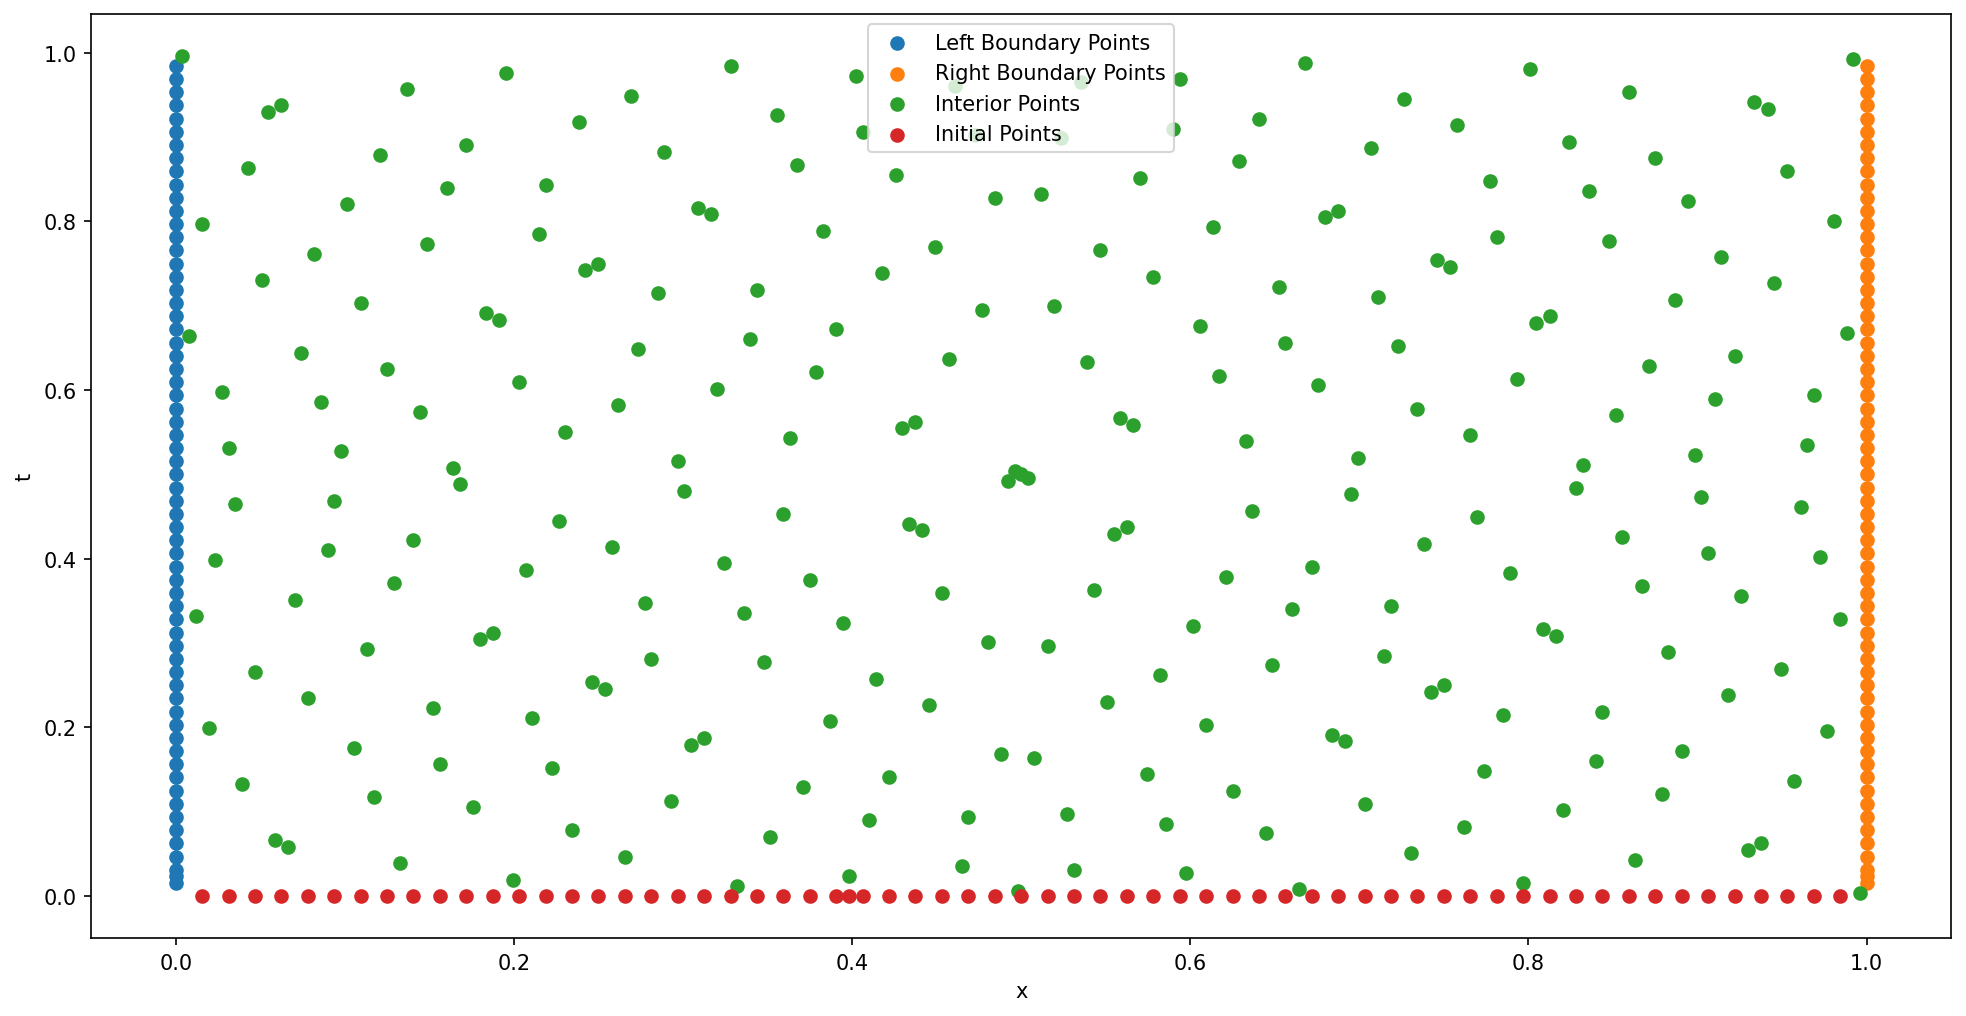

In [49]:
pde.plot_training_points()

In [50]:
history = pde.training(optimizer='lbfgs', config={'num_iterations': 1500, 'tolerance': 1e-5})
# history = pde.training(optimizer='adam', config={'num_epochs': 2000, 'learning_rate': 1e-3})

Starting L-BFGS optimization...
Loss: 0.981163 | Boundary Loss: -0.052987 | PDE Loss: -0.140190 | Iter: 0
Loss: -1.178186 | Boundary Loss: -2.614887 | PDE Loss: -1.375991 | Iter: 150
Loss: -2.401756 | Boundary Loss: -3.958840 | PDE Loss: -2.542784 | Iter: 300
Loss: -3.125141 | Boundary Loss: -5.067244 | PDE Loss: -3.177835 | Iter: 450
Loss: -3.487359 | Boundary Loss: -5.338959 | PDE Loss: -3.553232 | Iter: 600
Loss: -3.728803 | Boundary Loss: -5.367900 | PDE Loss: -3.842066 | Iter: 750
Loss: -3.830974 | Boundary Loss: -5.771535 | PDE Loss: -3.883868 | Iter: 900
Loss: -3.949291 | Boundary Loss: -5.873164 | PDE Loss: -4.004393 | Iter: 1050
Loss: -4.084988 | Boundary Loss: -5.976300 | PDE Loss: -4.144689 | Iter: 1200
Loss: -4.253242 | Boundary Loss: -6.048069 | PDE Loss: -4.329163 | Iter: 1350
Loss: -4.304150 | Boundary Loss: -6.149573 | PDE Loss: -4.371043 | Iter: 1500
Loss: -4.356739 | Boundary Loss: -6.183015 | PDE Loss: -4.426904 | Iter: 1650
Loss: -4.491482 | Boundary Loss: -6.393597

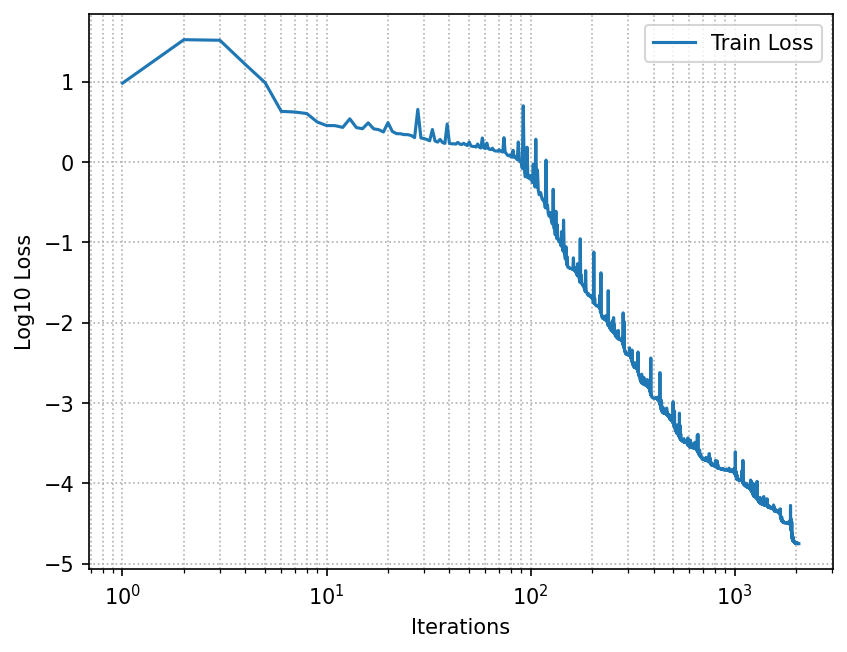

In [51]:
pde.plot_train_loss(history)

L2 Relative Error Norm: 9.649810e-04


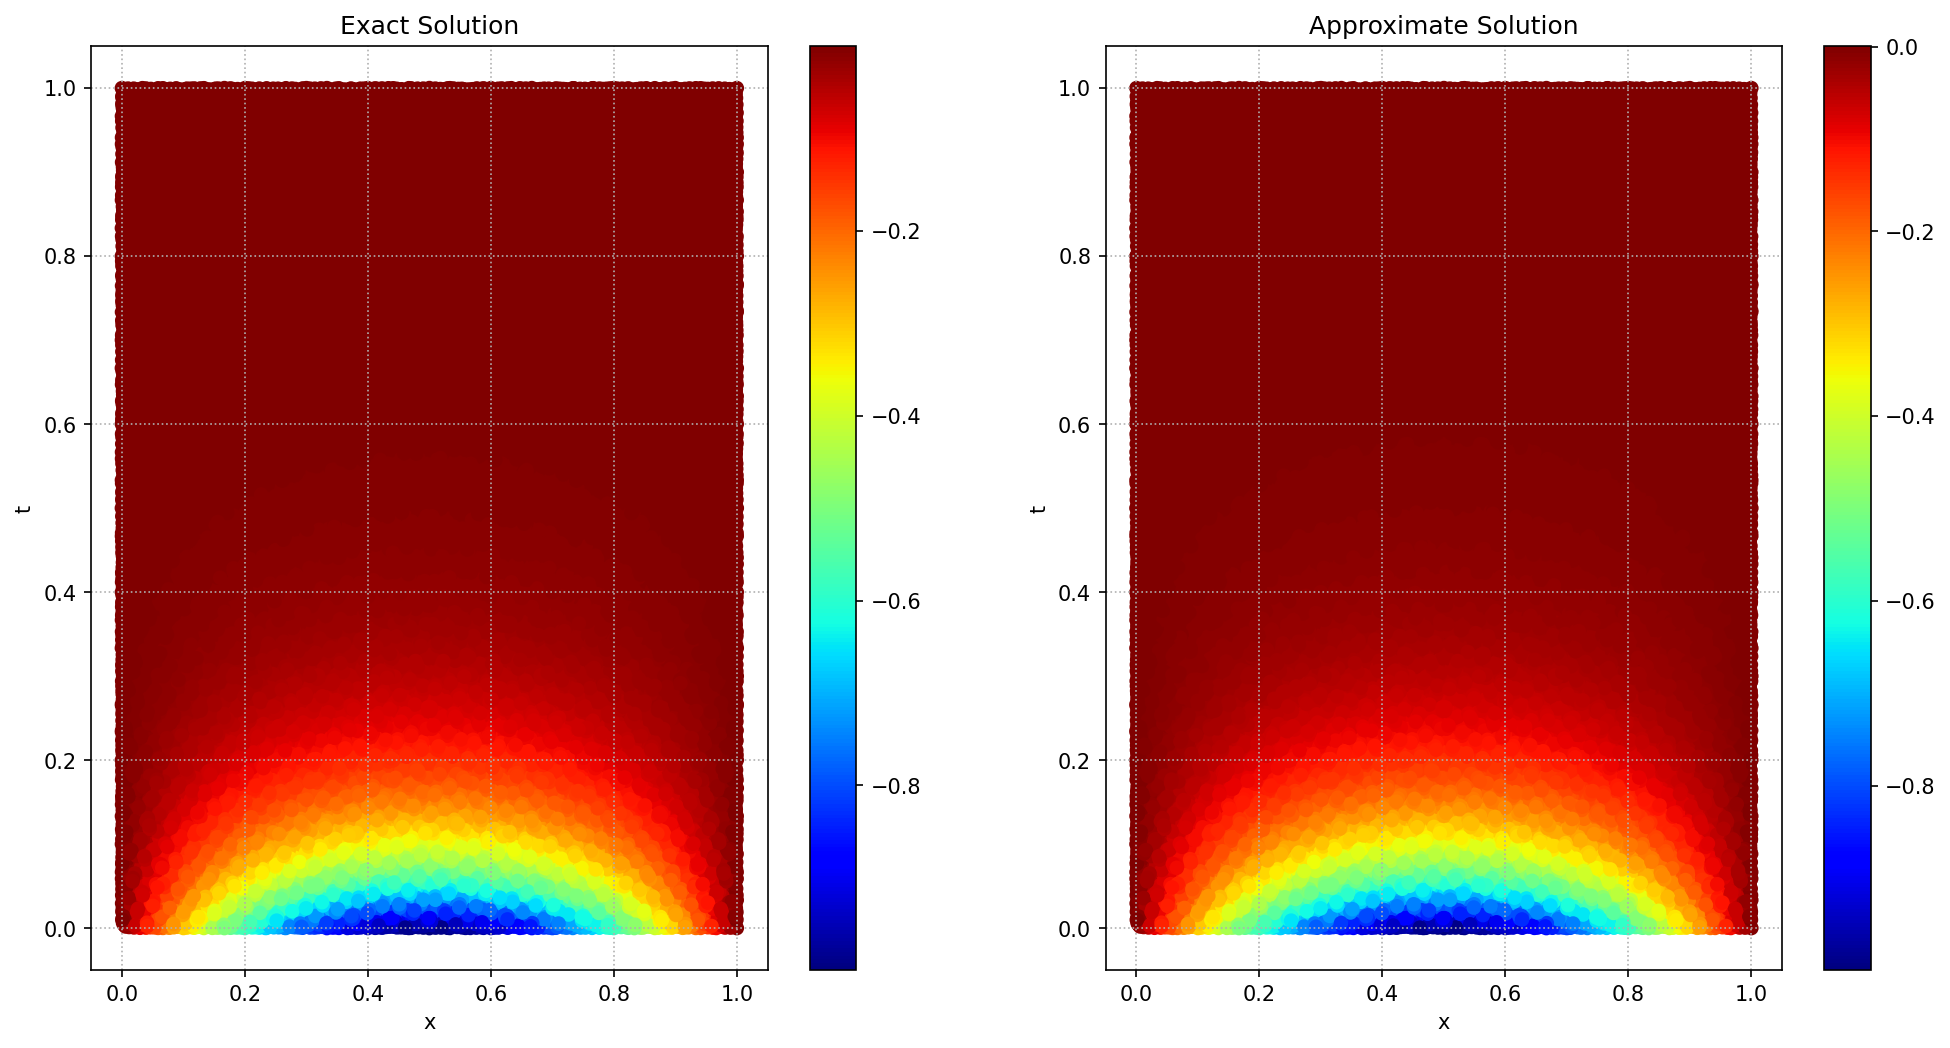

In [52]:
pde.plotting_solution()